### Main Page: 

[kaggle](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)

### Purpose

We are asking you to predict total sales for every product and store in the next month. 

### Q&A

[number of products only](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/57778)

### Download Data

``` sh
kaggle competitions download -c competitive-data-science-predict-future-sales
```

### Data Field Description

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### File Description
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv - supplemental information about the items categories.
- shops.csv - supplemental information about the shops.

### Evaluation 

Evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from scipy.stats import norm, skew
import seaborn as sns

In [18]:
%matplotlib inline
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# output each line result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
train_file_path = '../../data/predict_future_sales/sales_train.csv'
test_file_path = '../../data/predict_future_sales/test.csv'

In [8]:
items_file_path = '../../data/predict_future_sales/items.csv'
item_categories_file_path = '../../data/predict_future_sales/item_categories.csv'
shops_file_path = '../../data/predict_future_sales/shops.csv'

In [11]:
dr = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)

In [23]:
dr

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [24]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


In [18]:
items = pd.read_csv(items_file_path)
item_categories = pd.read_csv(item_categories_file_path)
shops = pd.read_csv(shops_file_path)

In [25]:
def join_category(dr):
    # dr get item_category_id by item_id
    return dr.join(items[['item_id', 'item_category_id']].set_index('item_id'), on='item_id')

In [19]:
len(dr)
dr.isnull().sum()

2935849

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [17]:
dr

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [20]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


In [109]:
train[['item_cnt_day']].groupby(['item_cnt_day']).count()

""
item_cnt_day
-22.0
-16.0
-9.0
-6.0
-5.0
-4.0
-3.0
-2.0
-1.0


In [112]:
print(train[['item_cnt_day']].apply(lambda x: ))
print(np.sum(train['item_cnt_day']))

item_cnt_day    3648206.0
dtype: float64
3648206.0


In [114]:
np.sum?

In [105]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


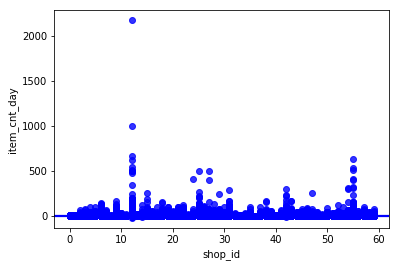

In [43]:
sns.regplot(x="shop_id", y="item_cnt_day", data=train, color='b')

In [60]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

In [82]:
len(train['item_cnt_day'])

2935849

In [84]:
norm.fit(train['item_cnt_day'])

(1.242640885140891, 2.6188339848856583)

In [101]:
train['item_cnt_day'].value_counts()

 1.0      2629372
 2.0       194201
 3.0        47350
 4.0        19685
 5.0        10474
-1.0         7252
 6.0         6338
 7.0         4057
 8.0         2903
 9.0         2177
 10.0        1820
 11.0        1263
 12.0        1083
 13.0         918
 14.0         716
 15.0         638
 16.0         544
 17.0         438
 18.0         391
 20.0         364
 19.0         347
 21.0         290
 22.0         242
 24.0         204
 23.0         198
 25.0         180
 26.0         176
 30.0         147
 28.0         131
 27.0         130
           ...   
 95.0           1
 96.0           1
 102.0          1
 105.0          1
 109.0          1
 112.0          1
 113.0          1
 118.0          1
 128.0          1
 129.0          1
 131.0          1
 132.0          1
 135.0          1
 146.0          1
 200.0          1
 147.0          1
 149.0          1
 153.0          1
 154.0          1
 156.0          1
 157.0          1
 504.0          1
 163.0          1
 164.0          1
 167.0    

In [123]:
train['item_cnt_day'].mean()
train['item_cnt_day'].median()

1.0

In [124]:
test['item_cnt_month'] = 1.0

In [125]:
# write file for submission
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['item_cnt_month'] = test['item_cnt_month']
sub.to_csv('/Users/albert_chen/workspace/result.csv',index=False)

In [121]:
test['item_cnt_month']

0         1.242641
1         1.242641
2         1.242641
3         1.242641
4         1.242641
5         1.242641
6         1.242641
7         1.242641
8         1.242641
9         1.242641
10        1.242641
11        1.242641
12        1.242641
13        1.242641
14        1.242641
15        1.242641
16        1.242641
17        1.242641
18        1.242641
19        1.242641
20        1.242641
21        1.242641
22        1.242641
23        1.242641
24        1.242641
25        1.242641
26        1.242641
27        1.242641
28        1.242641
29        1.242641
            ...   
214170    1.242641
214171    1.242641
214172    1.242641
214173    1.242641
214174    1.242641
214175    1.242641
214176    1.242641
214177    1.242641
214178    1.242641
214179    1.242641
214180    1.242641
214181    1.242641
214182    1.242641
214183    1.242641
214184    1.242641
214185    1.242641
214186    1.242641
214187    1.242641
214188    1.242641
214189    1.242641
214190    1.242641
214191    1.

1.24264088514 2.61883398489


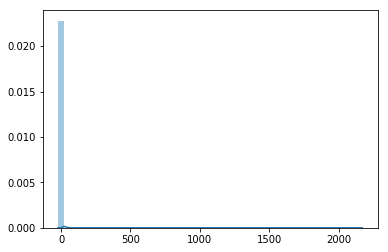

In [126]:
# Sale Price Distribution
(m, sigma) = norm.fit(train[['item_cnt_day']])
print(m, sigma)
sns.distplot(train[['item_cnt_day']])

item_cnt_day    138
dtype: int64


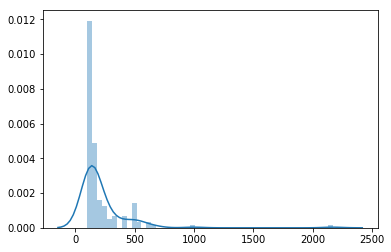

In [146]:
tmp = train[['item_cnt_day']].query('item_cnt_day > 100')
print(tmp.count())
tmp['item_cnt_day'].value_counts()
sns.distplot(tmp[['item_cnt_day']])